In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


# #My image
# file_path = '../Dropbox Files/hel1.pma'
# image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
# image = io.imread(image_path, as_gray=True)

# #Chanel image paths
# CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
# CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

# good_peaks_1,_ = good_peak_finder(CH1_img_path)
# good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# # Move good_peaks_1 to CH2 to display full image
# good_peaks_1_CH2 = shift_peaks(good_peaks_1)
# good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# # Poly Mapping
# CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
# CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

# params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
# mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
# poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)

#My image
file_path = "../new files _24_3_25/hel1.pma"
image_path = "../Benchmarking/hel1_Avg/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Benchmarking/hel1_Avg/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Benchmarking/hel1_AVg/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

#new coords for CH2:
CH1_peaks_10 = np.array([[18,92], [16,213], [108,43], [106, 176], [210,51], [234, 219], [366,12], [322,192], [478, 106], [502,160]])
CH2_peaks_10_new = np.array([[22,349],[19,470],[111,300],[108,433],[212,307],[234,475],[367,268],[321,448],[476,361],[499,414]])
params_x_man_10_new, params_y_man_10_new = find_polyfit_params(CH1_peaks_10, CH2_peaks_10_new, degree=3)
mapped_peaks_10_new = apply_polyfit_params(good_peaks_1, params_x_man_10_new, params_y_man_10_new).astype(np.uint16)
poly_pair_count_tol4_10_new, poly_pair_arr_CH1_tol4_10_new, poly_pair_arr_CH2_tol4_10_new = find_polyfit_pairs(mapped_peaks_10_new, good_peaks_1, tolerance=3)

#unshift CH2 peaks [+1, +10] to original position
poly_pair_arr_CH2_tol4_10_new_unshift = shift_peaks(poly_pair_arr_CH2_tol4_10_new, [1, 10])

#remove peaks in CH2 that are out of bounds 
poly_pair_arr_CH2_tol4_10_curr = poly_pair_arr_CH2_tol4_10_new_unshift[(poly_pair_arr_CH2_tol4_10_new_unshift[:,1] <= 502) & (poly_pair_arr_CH2_tol4_10_new_unshift[:, 0] <= 502)]
poly_pair_arr_CH1_tol4_10_curr = poly_pair_arr_CH1_tol4_10_new[(poly_pair_arr_CH2_tol4_10_new_unshift[:,1] <= 502) & (poly_pair_arr_CH2_tol4_10_new_unshift[:, 0] <= 502)]


In [2]:
# define key variables
y_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,0],poly_pair_arr_CH2_tol4_10_curr[:,0]))
x_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,1],poly_pair_arr_CH2_tol4_10_curr[:,1]))

circle_array = draw_circle(4, y_centres_hel1, x_centres_hel1, image.shape[0])
mask_new = (circle_array == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

In [3]:
def dynamic_global_background_subtraction_old(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
    frames_data = read_pma(pma_file_path) 
    corrected_frames_data = []
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]
    #filling in the circle
    for frame in frames_data: #frame is 1D
        all_peaks_intensity = 0
        for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
            for i in range(x_centre - radius, x_centre+ radius + 1):
                for j in range(y_centre - radius, y_centre + radius + 1):
                    if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                        all_peaks_intensity += int(frame[j][i])
        
        # by summing the third column of the array we exclude the yellow pixels from being included!
        total_intensity = np.sum(frame[:, :])
        #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
        intensity_to_remove = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)
        frame = frame.astype(np.int16)
        frame = np.clip(frame - intensity_to_remove, 0, 255).astype(np.uint8)
        corrected_frames_data.append(frame)

    return corrected_frames_data

In [4]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = dynamic_global_background_subtraction_old(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


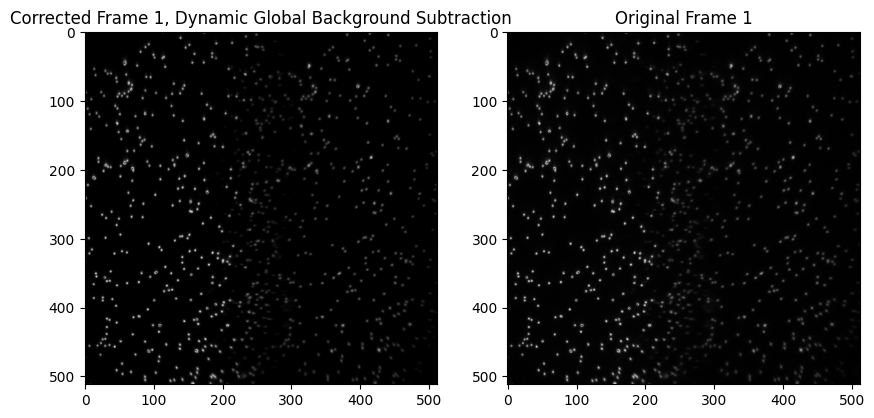

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(corrected_frames_data[0], cmap='gray')
ax[0].set_title('Corrected Frame 1, Dynamic Global Background Subtraction')

ax[1].imshow(Frames_data[0], cmap='gray')
ax[1].set_title('Original Frame 1')
plt.show()

In [6]:
print(Frames_data[100][454][30:40])
print(corrected_frames_data[100][454][30:40])

[ 25  13  14  43 128 169  89  21   9   8]
[ 22  10  11  40 125 166  86  18   6   5]


In [7]:
# This new function is much more efficient!
def dynamic_global_background_subtraction_new(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
    
    frames_data = read_pma(pma_file_path)
    height, width, _ = input_array.shape
    y_indices, x_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    circle_mask = np.zeros((height, width), dtype=bool)

    corrected_frames_data = []
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = height * width

    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        mask = (x_indices - x_centre) ** 2 + (y_indices - y_centre) ** 2 < radius ** 2
        circle_mask |= mask

    for frame in frames_data:  
        all_peaks_intensity = np.sum(frame[circle_mask])
        total_intensity = np.sum(frame)
        intensity_to_remove = np.int16((total_intensity - all_peaks_intensity) // (num_of_frame_pixels - num_of_peak_pixels))
        frame = frame.astype(np.int16) 
        frame -= intensity_to_remove 
        frame = np.clip(frame, 0, 255).astype(np.uint8)  # Clip and convert back
        corrected_frames_data.append(frame)

    return corrected_frames_data

In [8]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data_new = dynamic_global_background_subtraction_new(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data_new)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data_new[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data_new[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


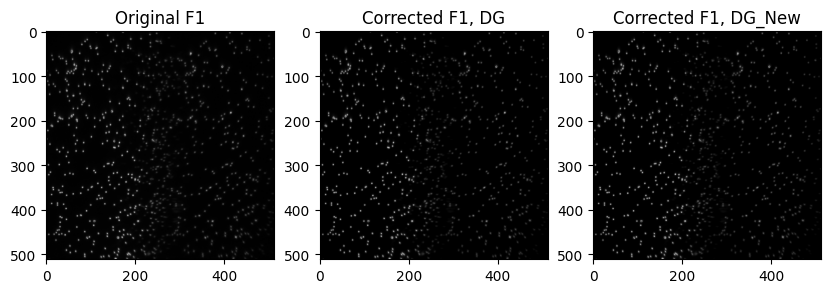

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].imshow(Frames_data[0], cmap='gray')
ax[0].set_title('Original F1')

ax[1].imshow(corrected_frames_data[0], cmap='gray')
ax[1].set_title('Corrected F1, DG')

ax[2].imshow(corrected_frames_data_new[0], cmap='gray')
ax[2].set_title('Corrected F1, DG_New')

plt.show()

In [10]:
print(Frames_data[20][454][30:40])
print(corrected_frames_data[20][454][30:40])
print(corrected_frames_data_new[20][454][30:40])

[ 23  13  13  31 100 150  90  24   9   7]
[ 19   9   9  27  96 146  86  20   5   3]
[ 19   9   9  27  96 146  86  20   5   3]
